In [4]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/MNIST/"
EPOCHS = 100
BATCH_SIZE = 128
IMAGE_SIZE = 28
IMAGE_CHANNEL = 1
NOISE_DIM = 100
LEARNING_RATE = 2e-4

In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()


In [6]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM, 1024),
            torch.nn.BatchNorm1d(num_features=1024),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=1024, out_features=128 * 7 * 7),
            torch.nn.BatchNorm1d(num_features=128*7*7),
            torch.nn.ReLU()
        )

        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )

        initialize_weights(self)

    def forward(self, x):
        output = x.view(-1,NOISE_DIM)
        output = self.fc(output)
        output = output.view(-1, 128, 7, 7)
        output =self.deconv(output)

        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=IMAGE_CHANNEL, out_channels=64, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.LeakyReLU(negative_slope=0.2)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, x):
        output = self.conv(x)
        output = output.view(-1, 128 * 7 * 7)
        output = self.fc(output)

        return output

In [7]:
NetG = Generator()
NetD = Discriminator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = torch.nn.BCELoss()

fix_noise = torch.FloatTensor(BATCH_SIZE, NOISE_DIM, 1, 1).normal_(0,1)
if torch.cuda.is_available():
    NetD = NetD.cuda()
    NetG = NetG.cuda()
    fix_noise = fix_noise.cuda()
    criterion.cuda()

fix_noise_var = torch.autograd.Variable(fix_noise)
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_dataset = tv.datasets.MNIST(root=DATA_PATH,
                               train=True,
                               transform=transform,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)



In [8]:
bar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    if epoch % 30 == 0:
        optimizerD.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10

    for ii, data in enumerate(train_loader,0):
        input,_=data
        label_real = torch.ones(input.size(0))
        label_fake = torch.zeros(input.size(0))
        noise = torch.randn(input.size(0),NOISE_DIM,1,1).normal_(0, 1)

        if torch.cuda.is_available():
            input = input.cuda()
            label_real = label_real.cuda()
            label_fake = label_fake.cuda()
            noise = noise.cuda()

        input_var = torch.autograd.Variable(input)
        label_real_var = torch.autograd.Variable(label_real)
        label_fake_var = torch.autograd.Variable(label_fake)
        noise_var = torch.autograd.Variable(noise)

        NetD.zero_grad()
        output=NetD(input_var)
        error_real=criterion(output.squeeze(),label_real_var)
        error_real.backward()

        fake_pic=NetG(noise_var).detach()
        output2=NetD(fake_pic)
        error_fake=criterion(output2.squeeze(),label_fake_var)

        error_fake.backward()
        error_D=error_real+error_fake
        optimizerD.step()

        NetG.zero_grad()
        fake_pic=NetG(noise_var)
        output=NetD(fake_pic)
        error_G=criterion(output.squeeze(),label_real_var)
        error_G.backward()

        optimizerG.step()
        bar.show(epoch, error_D.item(), error_G.item())

Epoch:1 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.788;G Loss:1.273,total=0:00:310
Epoch:2 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.493;G Loss:1.586,total=0:00:310
Epoch:3 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.635;G Loss:2.040,total=0:00:310
Epoch:4 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.512;G Loss:1.911,total=0:00:310
Epoch:5 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.833;G Loss:1.713,total=0:00:260
Epoch:6 / 100 [*******************************************************

Epoch:43 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.402;G Loss:2.098,total=0:00:20056:1649
Epoch:44 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.353;G Loss:2.793,total=0:00:20026:0709
Epoch:45 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.311;G Loss:2.703,total=0:00:20058:1457
Epoch:46 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.228;G Loss:2.805,total=0:00:20030:3327
Epoch:47 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.235;G Loss:3.006,total=0:00:20002:4446
Epoch:48 / 100 [**************

Epoch:85 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.190;G Loss:3.407,total=0:00:210:03:396
Epoch:86 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.282;G Loss:2.382,total=0:00:200:19:434
Epoch:87 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.212;G Loss:3.228,total=0:00:200:07:327
Epoch:88 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.249;G Loss:2.535,total=0:00:200:21:598
Epoch:89 / 100 [*********************************************************************************************************************] 469 / 469 ,D Loss:0.208;G Loss:2.728,total=0:00:240:36:3009
Epoch:90 / 100 [*************

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


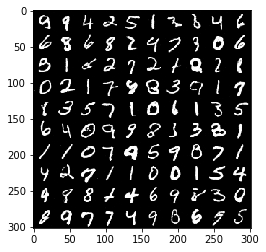

In [9]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10)
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))